# Load libraries

In [93]:
%matplotlib inline

import os
import math

import configparser

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import sys
sys.path.append('../..')

from scripps.utils import read_datasets, norm1d, bayesian_linear_regression

import seaborn as sns

In [17]:
#np.random.seed(23) #Not working

# Load all mark2cure citizen scientist annotations

In [2]:
CF = read_datasets.get_configuration()

def read_disease_annotations():
    annotations = pd.DataFrame()
    anno = read_datasets.load_dataset('m2c_citizen_disease', 'files1')
    anno[3].replace(['I-Disease', 'O'], [1, 0], inplace=True)
    annotations = pd.concat([annotations, anno[0].rename('Token')], axis=1)
    annotations = pd.concat([annotations, anno[3].rename('Annotator1')], axis=1)
    for i in range(2, 6):
        anno = read_datasets.load_dataset('m2c_citizen_disease', 'files{}'.format(i))
        anno[3].replace(['I-Disease', 'O'], [1, 0], inplace=True)
        annotations = pd.concat([annotations, anno[3].rename('Annotator{}'.format(i))], axis=1)
    return annotations

def read_phenotype_annotations():
    annotations = pd.DataFrame()
    anno = read_datasets.load_dataset('m2c_citizen_phenotype', 'files1')
    anno[3].replace(['I-Phenotype', 'O'], [1, 0], inplace=True)
    annotations = pd.concat([annotations, anno[0].rename('Token')], axis=1)
    annotations = pd.concat([annotations, anno[3].rename('Annotator1')], axis=1)
    for i in range(2, 6):
        anno = read_datasets.load_dataset('m2c_citizen_phenotype', 'files{}'.format(i))
        anno[3].replace(['I-Phenotype', 'O'], [1, 0], inplace=True)
        annotations = pd.concat([annotations, anno[3].rename('Annotator{}'.format(i))], axis=1)
    return annotations

In [3]:
disease_annotations = read_disease_annotations()
phenotype_annotations = read_phenotype_annotations()

# Load original annotations

In [13]:
def read_both_annotations():
    annotations = pd.DataFrame()
    anno = read_datasets.load_dataset('m2c', 'files1')
    anno[3].replace(['I-?', 'I-Disease_Phen', 'I-Gene'], ['O', 'I-Disease_Pheno', 'O'], inplace=True)
    annotations = pd.concat([annotations, anno[0].rename('Token')], axis=1)
    annotations = pd.concat([annotations, anno[3].rename('Annotator1')], axis=1)
    for i in range(2, 6):
        anno = read_datasets.load_dataset('m2c', 'files{}'.format(i))
        anno[3].replace(['I-?', 'I-Disease_Phen', 'I-Gene'], ['O', 'I-Disease_Pheno', 'O'], inplace=True)
        annotations = pd.concat([annotations, anno[3].rename('Annotator{}'.format(i))], axis=1)
    return annotations

def sanity_check(annotations, columns, values):
    for col in columns:
        assert set(annotations[col].unique()) == set(values)


In [14]:
mixed_annotations = read_both_annotations()
sanity_check(mixed_annotations, ['Annotator1', 'Annotator2', 'Annotator3', 'Annotator4', 'Annotator5'], ['I-Disease', 'I-Phenotype', 'I-Disease_Pheno', 'O'])

# Filter relevant rows

In [15]:
def get_relevant_rows(annotations):
    relevant = annotations[['Annotator1', 'Annotator2', 'Annotator3', 'Annotator4', 'Annotator5']] != 'O'
    relevant = annotations[relevant.all(axis=1)]
    return relevant

In [16]:
relevant_annotations = get_relevant_rows(mixed_annotations)

In [25]:
disease_annotations = disease_annotations.iloc[relevant_annotations.index]
phenotype_annotations = phenotype_annotations.iloc[relevant_annotations.index]

# Initialize latent variables

In [55]:
K = disease_annotations.shape[0]
J = disease_annotations.shape[1] - 1

latent = {}

latent['theta'] = np.zeros(K)
latent['d_alpha'] = np.zeros(J)
latent['d_beta'] = np.zeros(J)
latent['d_z'] = np.zeros((K, J))

latent['p_alpha'] = np.zeros(J)
latent['p_beta'] = np.zeros(J)
latent['p_z'] = np.zeros((K, J))

#Should these be separate for disease and phenotype?
latent['b0'] = np.zeros(2)
latent['B0_scale'] = 1
latent['m0'] = np.zeros(K) #TODO: ask HS regarding changing certain values here.
latent['C0_scale'] = 1

latent['K'] = K
latent['J'] = J

# Define functions for resampling using Gibbs sampling

In [48]:
def __get_alpha_beta_z(mode):
    if mode == 'disease':
        alpha = latent['d_alpha']
        beta = latent['d_beta']
        z = latent['d_z']
    else:
        alpha = latent['p_alpha']
        beta = latent['p_beta']
        z = latent['p_z']
    return alpha, beta, z
    

In [49]:
def __resample_z(alpha, beta, z, annotations):
    interval = [-100, 100] #Should this be changed?
    for k in range(K):
    #for k in annotations.index:
        for j in range(J):
            mean = alpha[j] + beta[j]*latent['theta'][k]
            std_dev = 1
            '''
            if(annotations['Annotator{}'.format(j+1)][k] == 0):
                z[k, j] = norm1d.truncnormal(mean, std_dev, interval[0], 0)
            elif(annotations['Annotator{}'.format(j+1)][k] == 1):
                z[k, j] = norm1d.truncnormal(mean, std_dev, 0, interval[1])
            '''
            if(annotations['Annotator{}'.format(j+1)][annotations.index[k]] == 0):
                z[k, j] = norm1d.truncnormal(mean, std_dev, interval[0], 0)
            elif(annotations['Annotator{}'.format(j+1)][annotations.index[k]] == 1):
                z[k, j] = norm1d.truncnormal(mean, std_dev, 0, interval[1])
    
def resample_z(mode):
    alpha, beta, z = __get_alpha_beta_z(mode)
    if mode == 'disease':
        annotations = disease_annotations
    else:
        annotations = phenotype_annotations
    __resample_z(alpha, beta, z, annotations)

In [50]:
def __resample_alpha_beta(alpha, beta, z):
    for j in range(J):
        Y = z[:, j]
        X = np.vstack((np.ones(K), latent['theta'])).T
        
        WN, VN = bayesian_linear_regression.linreg_post(X, Y, latent['b0'], latent['B0_scale'], 1)
        sample = np.random.multivariate_normal(WN, VN)
        alpha[j] = sample[0]
        beta[j] = sample[1]

def resample_alpha_beta(mode):
    alpha, beta, z = __get_alpha_beta_z(mode)
    __resample_alpha_beta(alpha, beta, z)

In [51]:
def resample_theta():
    for k in range(K):
        #Y = latent['d_z'][k, :] - latent['d_alpha'] + latent['p_z'][k, :] - latent['p_alpha']
        #X = latent['d_beta'] + latent['p_beta']
        Y = np.concatenate(((latent['d_z'][k, :] - latent['d_alpha']), (latent['p_z'][k, :] - latent['p_alpha'])), axis=0)
        X = np.concatenate((latent['d_beta'], latent['p_beta']), axis=0)
        X = np.reshape(X, (-1, 1))
        WN, VN = bayesian_linear_regression.linreg_post(X, Y, latent['m0'][k], latent['C0_scale'], 1)
        latent['theta'][k] = np.random.normal(WN, math.sqrt(VN))

In [56]:
def save_latent_variables():
    #TODO: save to csv.
    pass


def resample():
    resample_z('disease')
    resample_z('phenotype')
    resample_theta()
    resample_alpha_beta('disease')
    resample_alpha_beta('phenotype')
    
    save_latent_variables()
    
def has_converged():
    #TODO
    pass
    
def run_sampling(num_iter, thresh, print_freq=50):
    #TODO: consider first step, when we decide if word is relevant or not.
    thetas = []
    for it in xrange(1, num_iter+1):
        resample()
        if it%print_freq == 0:
            print 'Iter {}/{} done.'.format(it, num_iter)
        if has_converged():
            break
        if it > thresh:
            thetas.append(latent['theta'])
    return thetas


In [70]:
num_iter = 2000
thresh = 300
thetas = run_sampling(num_iter, thresh)

Iter 5/2000 done.
Iter 10/2000 done.
Iter 15/2000 done.
Iter 20/2000 done.
Iter 25/2000 done.
Iter 30/2000 done.
Iter 35/2000 done.
Iter 40/2000 done.
Iter 45/2000 done.
Iter 50/2000 done.
Iter 55/2000 done.
Iter 60/2000 done.
Iter 65/2000 done.
Iter 70/2000 done.
Iter 75/2000 done.
Iter 80/2000 done.
Iter 85/2000 done.
Iter 90/2000 done.
Iter 95/2000 done.
Iter 100/2000 done.
Iter 105/2000 done.
Iter 110/2000 done.
Iter 115/2000 done.
Iter 120/2000 done.
Iter 125/2000 done.
Iter 130/2000 done.
Iter 135/2000 done.
Iter 140/2000 done.
Iter 145/2000 done.
Iter 150/2000 done.
Iter 155/2000 done.
Iter 160/2000 done.
Iter 165/2000 done.
Iter 170/2000 done.
Iter 175/2000 done.
Iter 180/2000 done.
Iter 185/2000 done.
Iter 190/2000 done.
Iter 195/2000 done.
Iter 200/2000 done.
Iter 205/2000 done.
Iter 210/2000 done.
Iter 215/2000 done.
Iter 220/2000 done.
Iter 225/2000 done.
Iter 230/2000 done.
Iter 235/2000 done.
Iter 240/2000 done.
Iter 245/2000 done.
Iter 250/2000 done.
Iter 255/2000 done.


In [71]:
avg_theta = np.sum(thetas, axis=0)/(num_iter - thresh)

In [35]:
latent['d_z'][0]

array([-1.9652955 , -1.46644659,  1.01228079, -1.17087107,  0.04189509])

In [36]:
latent['p_z'][0]

array([0.24986465, 0.44928341, 0.57811906, 0.36945327, 0.27177063])

In [37]:
disease_annotations.iloc[0:2]

,Token,Annotator1,Annotator2,Annotator3,Annotator4,Annotator5
0,Haematuria,0,0,1,0,1
1,and,0,0,0,0,0


In [38]:
phenotype_annotations.iloc[0:2]

,Token,Annotator1,Annotator2,Annotator3,Annotator4,Annotator5
0,Haematuria,1,1,1,1,1
1,and,0,0,0,0,0


In [57]:
def get_annotator_bias(alpha, beta):
    # compute xr and xa using above latent vars.
    xa = (4*alpha - beta*beta)/(4*beta)
    xr = (4*alpha + beta*beta)/(4*beta)
    return xa, xr

def get_word_position(theta, tokens):
    # convert theta locations to an interval [-1, 1]?    
    x_coords = theta
    y_coords = np.zeros(theta.size)

    for i, token in enumerate(tokens):
        x = x_coords[i]
        y = y_coords[i]
        #plt.scatter(x, y, marker='x', color='red')
        #plt.text(strx+0.3, y+0.3, token, fontsize=9)
    #plt.show()

def plot_bias():
    # show the annotator's location along with the word's true position.
    pass


In [40]:
def alignment_to_expert_positions():
    pass

In [41]:
xpa, xpr = get_annotator_bias(latent['p_alpha'], latent['p_beta'])

In [42]:
xpa

array([ -6.32706321,  -6.26267304,  -4.79507159,  -3.45000494,
       -35.01257311])

In [43]:
xpr

array([ -6.18463574,  -6.11864038,  -4.61677148,  -3.21371276,
       -34.99302947])

In [44]:
xda, xdr = get_annotator_bias(latent['d_alpha'], latent['d_beta'])

In [45]:
xda

array([-2.68236481, -2.77872704, -2.92300426, -3.41072971, -2.18226219])

In [46]:
xdr

array([-2.39821931, -2.49903099, -2.64075262, -3.1677985 , -1.8575463 ])

In [47]:
xpa - xpr

array([-0.14242748, -0.14403266, -0.17830012, -0.23629218, -0.01954364])

In [48]:
xda - xdr

array([-0.28414549, -0.27969605, -0.28225163, -0.24293122, -0.32471589])

In [52]:
print min(latent['theta'])
print max(latent['theta'])

-3.968121542913008
4.425832840950601


In [88]:
print len(relevant_annotations)
print len(avg_theta)
relevant_annotations = relevant_annotations.reset_index()

503
503


In [92]:
pos = pd.DataFrame()
pos = pd.concat([pos, relevant_annotations[['Token', 'Annotator1', 'Annotator2', 'Annotator3', 'Annotator4', 'Annotator5']]])
#pos = pd.concat([pos, disease_annotations['Annotator1']])
#pos = pd.concat([pos, disease_annotations['Annotator1']])
pos = pd.concat([pos, pd.Series(latent['theta'])], axis=1)
pos

,Token,Annotator1,Annotator2,Annotator3,Annotator4,Annotator5,0
0,Haematuria,I-Phenotype,I-Phenotype,I-Disease_Pheno,I-Phenotype,I-Disease_Pheno,1.353472
1,abdominal,I-Disease,I-Disease,I-Disease,I-Disease_Pheno,I-Disease,-0.830908
2,aortic,I-Disease,I-Disease,I-Disease,I-Disease_Pheno,I-Disease,0.224815
3,aneurysm,I-Disease,I-Disease,I-Disease,I-Disease_Pheno,I-Disease,0.103402
4,Haematuria,I-Phenotype,I-Phenotype,I-Disease_Pheno,I-Phenotype,I-Disease_Pheno,1.256662
5,pain,I-Phenotype,I-Phenotype,I-Disease_Pheno,I-Phenotype,I-Phenotype,1.431297
6,abdominal,I-Disease,I-Disease,I-Disease,I-Disease_Pheno,I-Disease,-0.564934
7,aortic,I-Disease,I-Disease,I-Disease,I-Disease_Pheno,I-Disease,0.190602
8,Acanthosis,I-Disease,I-Disease_Pheno,I-Disease_Pheno,I-Disease_Pheno,I-Disease,0.530279
9,nigricans,I-Disease,I-Disease_Pheno,I-Disease_Pheno,I-Disease_Pheno,I-Disease,0.379689


In [101]:
def plot_thetas(pos_annos, annotator):
    pos_annos['zeros'] = 0
    ax = sns.scatterplot(x=0, y="zeros", hue=annotator, data=pos_annos)

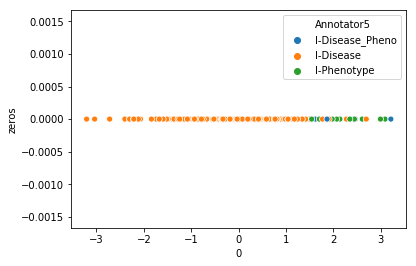

In [106]:
plot_thetas(pos, 'Annotator1')